In [1]:
from feos_pcsaft.dft import ExternalPotential, PcSaftFunctional, Adsorption1D, Geometry, Pore1D, State, Pore3D, Adsorption3D, DFTSolver, PhaseEquilibrium
from feos_pcsaft import PcSaftParameters
from feos_pcsaft.si import ANGSTROM, KELVIN, BAR, NAV, KILO, METER, MOL, KILOGRAM

import pandas as pd
import numpy as np
import os
import json
from scipy.spatial import Voronoi, distance, voronoi_plot_2d
from itertools import permutations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
####### class to read solid structures (Johannes) ############

class SolidStructure:

    N_atom = 0
    dimensions = {
        "Lx": 0.0,
        "Ly": 0.0,
        "Lz": 0.0
    }
    forcefield = ''
    total_mass = 0.0

    def __init__(self,structure):
 
        self.name = structure

        database = os.path.join(os.getcwd(),'structure_parameters','solid_database.json')
    
        with open(database) as f:
            data = json.load(f)

            for i in range(len(data)):
                if data[i]['Name']==self.name:
                    self.N_atom = data[i]['N_atom']
                    self.dimensions = data[i]['Dimensions']
                    self.forcefield = data[i]['Forcefield']
                    
                    
    def read_structure(self):
        struct_param = os.path.join(os.getcwd(),'structure_parameters')
        structure_df = pd.read_csv(os.path.join(struct_param,'{}.dat'.format(self.name)),names=['x','y','z','Type'], delim_whitespace=True)
        
        filename = os.path.join(struct_param,'{}.dat'.format(self.forcefield))
        forcefield_df = pd.read_csv(filename,names=['Type','sigma','epsilon','mass'], delim_whitespace=True)

        coordinates = np.array([structure_df["x"], structure_df["y"], structure_df["z"]])
        
        sigma_ss = np.zeros(len(structure_df["x"]))
        epsilon_k_ss = np.zeros_like(sigma_ss)
        
        for i in range(len(sigma_ss)):
            sigma_ss[i] = forcefield_df.sigma[forcefield_df.Type==structure_df["Type"][i]]
            epsilon_k_ss[i] = forcefield_df.epsilon[forcefield_df.Type==structure_df["Type"][i]]
        
        self.total_mass = np.sum(np.array([forcefield_df.mass[forcefield_df.Type==t]for t in structure_df.Type])) * 1.66054e-27

        return coordinates, sigma_ss, epsilon_k_ss   

In [3]:
#########  Read one example structure ########
# structure = SolidStructure('FAU_SI_2_2_2')
structure = SolidStructure('FAU_SI_1_1_1')
coordinates, sigma_ss, epsilon_ss = structure.read_structure()
system_size = [structure.dimensions["Lx"] * ANGSTROM, structure.dimensions["Lx"] * ANGSTROM, structure.dimensions["Lx"] * ANGSTROM]


In [4]:
# coords = np.array([[0,0],[0,1],[1,1 ], [1,0]])
# coords =np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],[2, 0], [2, 1], [2, 2], [0,3], [3,0]])
coords =np.array([[-1, 1], [0, 1], [0, 2], [1, 0], [1, 3], [1, 2],[2, 0], [2, 1], [2, 2], [0,3], [3,0]])
voron= Voronoi(coords)

In [5]:
verts = voron.vertices
verts

array([[ 3.5,  1.5],
       [ 1.5,  0.5],
       [ 2.5,  0.5],
       [-1.5,  2.5],
       [-0.5, -0.5],
       [-0.5,  1.5],
       [ 1.5,  2.5],
       [ 1.5,  1.5],
       [ 0.5,  1.5],
       [ 0.5,  2.5],
       [ 1. ,  1. ]])

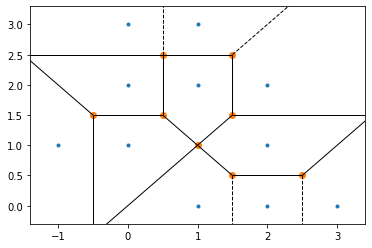

In [6]:
fig = voronoi_plot_2d(voron, figsize=[5,5])
plt.show()

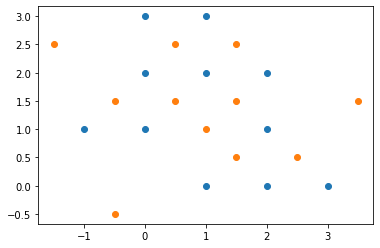

In [7]:
plt.scatter(coords[:,0], coords[:,1])
plt.scatter(verts[:,0], verts[:,1])


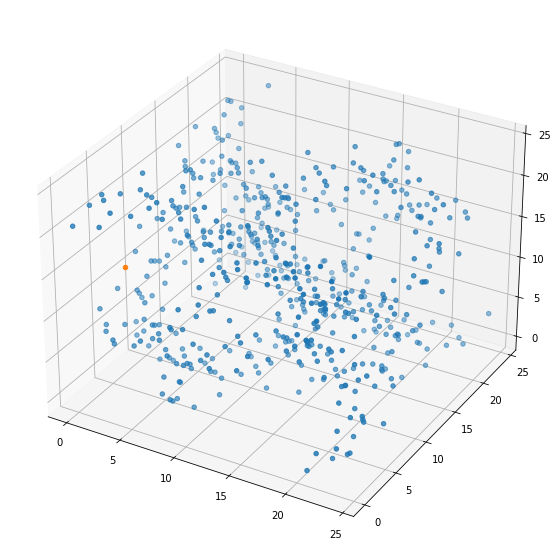

In [14]:
########## Plot example structure ##########

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=coordinates[0,:], ys=coordinates[1,:], zs=coordinates[2,:], marker='o')
# ax.scatter(xs=vertices[:,0], ys=vertices[:,1], zs=vertices[:,2], marker='o')
ax.scatter(xs=pore_center[0], ys=pore_center[1], zs=pore_center[2], marker='o')


plt.show()

In [15]:
%%time
vor = Voronoi(coordinates.T)
vertices = vor.vertices

CPU times: user 62.6 ms, sys: 723 µs, total: 63.3 ms
Wall time: 61.2 ms


In [16]:
minimum_distance = 0.0
dist = np.zeros(int(vor.vertices.size / 3)+1)

array([0.        , 0.        , 0.        , ..., 1.9847616 , 1.87002917,
       0.        ])

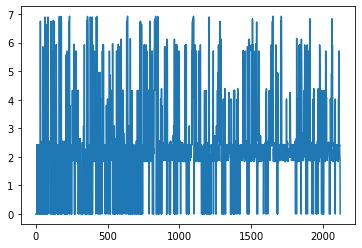

In [17]:
for i,point in enumerate(vor.vertices):
    if(point[0] >= 0.0 and point[0] <= structure.dimensions["Lx"] and point[1] >= 0.0 and point[1] <= structure.dimensions["Ly"] and point[2] >= 0.0 and point[2] <= structure.dimensions["Lz"]):
        dist[i] = np.min(distance.cdist(np.array([point]),coordinates.T))
        
plt.plot(dist)
dist

In [18]:
pore_radius = np.max(dist)
print(pore_radius,np.argmax(dist))
pore_center = [vor.vertices[np.argmax(dist)][0], vor.vertices[np.argmax(dist)][1], vor.vertices[np.argmax(dist)][2]]
print(pore_center)

#not sure: 
# n_pores= (structure.dimensions["Lx"]/(5.9595*2.0))**3
# print(f"number of pores= {n_pores}")
print(f"system_size = {np.array(system_size)}, pore_center = {pore_center},  pore_radius = {pore_radius}")

6.925179921949163 835
[2.9085472285415794, 2.908547228541578, 15.19497162231873]
system_size = [2.4257999999999997 nm 2.4257999999999997 nm 2.4257999999999997 nm], pore_center = [2.9085472285415794, 2.908547228541578, 15.19497162231873],  pore_radius = 6.925179921949163


In [25]:
######## Read parameters and create functional #########
params = PcSaftParameters.from_json(['carbon-dioxide'],'../parameters/20191105_pure_parameters.json')
# params = PcSaftParameters.from_json(['argon'],'structure_parameters/noble_gases.json')
func = PcSaftFunctional(params)
print(params)

PcSaftParameters(
	molarweight=[44.0098]
	m=[1.5131]
	sigma=[3.1869]
	epsilon_k=[163.333]
	q=[4.4]
)


In [26]:
###### set temperature, unit conversion between Lj and SI and calculate mean density from simulation ######
temperature = 298 *KELVIN

In [27]:
###### calculate VLE to compare bulk densities #########
vle = PhaseEquilibrium.pure_t(func, temperature)
vle

||temperature|density|
|-|-|-|
|phase 1|298.00000 K|5.31301 kmol/m³|
|phase 2|298.00000 K|15.97752 kmol/m³|


In [28]:
######  create state --> this is actually used for entropy scaling ########
### density is set to match the "bulk" value of the MD-simulation
state = State(func, temperature, pressure=1*BAR)# density=0.9*vle.vapor.density)
state

|temperature|density|
|-|-|
|298.00000 K|40.56629  mol/m³|

In [21]:
########### Create potential and initialize Pore Profile 1D ##########

potential = ExternalPotential.FreeEnergyAveraged(coordinates * ANGSTROM, sigma_ss, epsilon_ss, pore_center, system_size, [51, 51], cutoff_radius = 14*ANGSTROM)
# potential = ExternalPotential.FreeEnergyAveraged(coordinates_new * ANGSTROM, sigma_ss_new, epsilon_ss_new, pore_center, system_size, [51, 51])
# pore = Pore1D(func, Geometry.Spherical, 6.84534814234455 * ANGSTROM, potential, 128)
pore_raw = Pore1D(func, Geometry.Spherical, pore_radius * ANGSTROM, potential, 128)

In [22]:
pore= pore_raw.initialize(state)

[/usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/adsorption/fea_potential.rs:101] weights_sum = 12.566370614359169
[/usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/adsorption/fea_potential.rs:138] temperature = 298.0


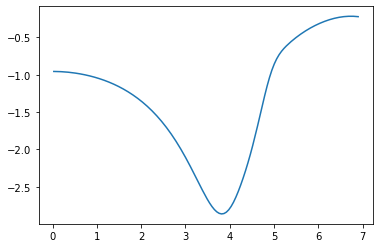

In [23]:
plt.plot(pore.z/ANGSTROM, pore.external_potential[0,:])

In [24]:
pore

In [25]:
####### Calculate isotherm 1D ########
isotherm1D = Adsorption1D.adsorption_isotherm(func, 200.0 * KELVIN, (1.0e-3 * BAR, 10.0 * BAR, 5), pore_raw)

[/usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/adsorption/fea_potential.rs:101] weights_sum = 12.566370614359169
[/usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/feos-dft/src/adsorption/fea_potential.rs:138] temperature = 200.0


In [45]:
isotherm1D.total_adsorption*NAV

array([8.25699500e-04, 2.13716759e+00, 4.15514296e+00, 5.86896429e+00,
       7.34780436e+00])

array([[8.90555333e-02, 2.17189114e+02, 3.22611712e+02, 3.87828788e+02]])

In [29]:
####### Initialize 3D Pore #########
pore3D = Pore3D(func, system_size, [64,64,64],coordinates* ANGSTROM, sigma_ss, epsilon_ss)

In [30]:
pore3D = pore3D.initialize(state)

In [31]:
# pore3D.x

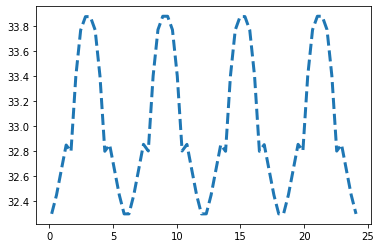

In [32]:
plt.plot(pore3D.x/ANGSTROM, np.mean(pore3D.external_potential[0,:,:,:], axis=(1,2)),'--', label='3D - mean', linewidth=3)

In [38]:
solver = DFTSolver(output=True).picard_iteration(max_iter=25, beta=0.001).anderson_mixing()

In [ ]:
%%time
pore3D.solve(solver=solver)

In [35]:
pore3D.total_moles*NAV#*factor#*NAV

0.0956283778513739

In [66]:
sigma_new = np.zeros_like(sigma_ss)
sigma_new[sigma_ss==3] = 16
sigma_new[sigma_ss==0] = 28
m_unit = sum(sigma_new)
m_unit_kg = m_unit * 1.660539e-27 * KILOGRAM
factor = 1.0/m_unit_kg
print(f'The mass of one unit cell is m = {m_unit}u. This equals {m_unit_kg}. The factor between one unit cell and a kg of solid is {factor}')

The mass of one unit cell is m = 11520.0u. This equals 1.9129409279999998e-20  g. The factor between one unit cell and a kg of solid is 5.2275529545259434e22 kg^-1


In [144]:
######## Calculate 3D isotherm ########
solver = None
### for 3D sometimes need to specify more safe solver 
# solver = DFTSolver(output=False).picard_iteration(tol=1.0e-5, beta=0.01, max_iter=20, log=False).anderson_mixing(tol=1.0e-9,mmax=10)#
isotherm3D = Adsorption3D.adsorption_isotherm(func, 120.0 * KELVIN, (1.0e-3 * BAR, 8.0 * BAR, 5), pore3D, solver=solver)

In [146]:
isotherm3D.total_adsorption


thread '<unnamed>' panicked at 'Inconsistent units mol and mol/m²', /usr/ITT/bursik/.cargo/registry/src/github.com-1ecc6299db9ec823/quantity-0.4.1/src/lib.rs:929:17


PanicException: Inconsistent units mol and mol/m²

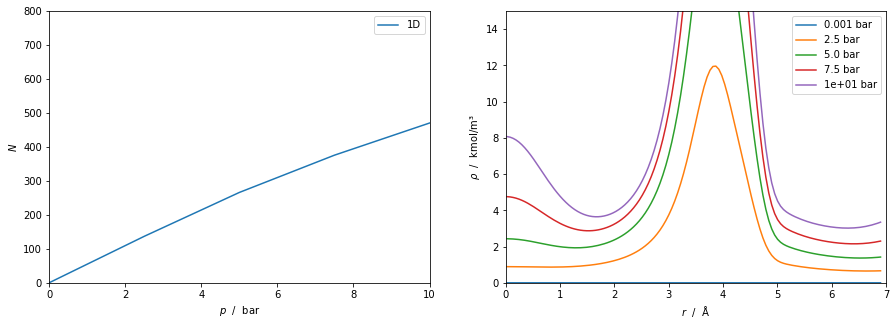

In [28]:
###### Plot 1D and 3D isotherms #########
f, ax = plt.subplots(1,2,figsize=(15,5))
# ax[0].plot(isotherm3D.pressure/BAR, isotherm3D.total_adsorption*NAV,'o', label="3D")
ax[0].plot(isotherm1D.pressure/BAR, isotherm1D.total_adsorption*NAV*64, label="1D")
ax[0].set_xlabel('$p~~/~~\\mathrm{bar}$')
ax[0].set_ylabel('$N$')
ax[0].legend()
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,800)

for profile in isotherm1D.profiles[:10]:
    ax[1].plot(profile.r/ANGSTROM, (profile.density/(KILO*MOL/METER**3)).T, label=f'{profile.bulk.pressure()/BAR:.2} bar')
ax[1].set_xlabel('$r~~/~~\\mathrm{\AA}$')
ax[1].set_ylabel('$\\rho~~/~~\\mathrm{kmol/m³}$')
ax[1].set_xlim(0,7)
ax[1].set_ylim(0,15)
ax[1].legend()

In [ ]:
## plt.plot(isotherm3D.profiles[-1].x/ANGSTROM, (isotherm3D.profiles[-1].density/(KILO*MOL/METER**3))[0,30,30,:])

In [44]:
import scipy.integrate as spin

spin.trapezoid(isotherm1D.profiles[-1].density*NAV*ANGSTROM**3 *4*3.141*(isotherm1D.profiles[-1].z/ANGSTROM) **2,isotherm1D.profiles[-1].z/ANGSTROM )*64

array([93.38036118])